In [115]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [116]:
filepath = os.path.join(os.path.abspath(''), 'data', 'heart.csv')
heart = pd.read_csv(filepath)

# Data analysis

In [117]:
heart.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [118]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [119]:
heart.isnull().sum()


age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

# Models

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import robust_scale
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [121]:
df = heart

df_ = pd.get_dummies(df, columns=['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall'], drop_first = True)

In [122]:
X_ = df_.drop(['output'], axis=1)
y = df_['output']

In [123]:
for col in ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']:
    X_[col] = robust_scale(X_[col])

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size = 0.3, random_state = 521)

# Logistic Regression

In [125]:
score = 0
scores = []

for i in np.logspace(-5, 5, 100):
    clf = LogisticRegression(random_state=563, penalty='l2', C=i, max_iter=1000, solver='liblinear').fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
    if scores[-1] > score:
        score = clf.score(X_test, y_test)
        alpha = i

In [126]:
print(alpha)

2.2570197196339215


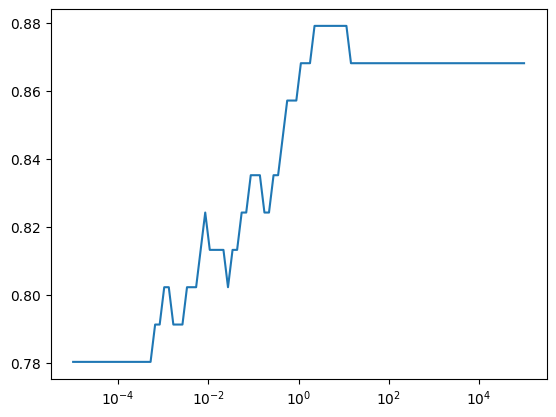

In [127]:
plt.semilogx(np.logspace(-5, 5, 100), scores)

In [128]:
clf = LogisticRegression(random_state=563, penalty='l2', C=alpha, max_iter=1000, solver='liblinear').fit(X_train, y_train)
pred = clf.predict(X_test)
clf.score(X_test, y_test)

0.8791208791208791

# Feature space

In [129]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import FeatureSpace
from keras import layers, Sequential, Input, regularizers
import pydot
import graphviz

In [130]:
val_dataframe = df.sample(frac=0.3, random_state=612)
train_dataframe = df.drop(val_dataframe.index)

In [131]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop('output')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [132]:
train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)


In [133]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [134]:
feature_space = FeatureSpace(
    features={
        # Categorical features encoded as integers
        "sex": FeatureSpace.integer_categorical(num_oov_indices=0),
        "cp": FeatureSpace.integer_categorical(num_oov_indices=0),
        "fbs": FeatureSpace.integer_categorical(num_oov_indices=0),
        "restecg": FeatureSpace.integer_categorical(num_oov_indices=0),
        "exng": FeatureSpace.integer_categorical(num_oov_indices=0),
        "caa": FeatureSpace.integer_categorical(num_oov_indices=0),
        "thall": FeatureSpace.integer_categorical(num_oov_indices=0),

        # Numerical features to normalize
        "age": FeatureSpace.float_discretized(num_bins=30),
        
        # Numerical features to normalize
        "trtbps": FeatureSpace.float_normalized(),
        "chol": FeatureSpace.float_normalized(),
        "oldpeak": FeatureSpace.float_normalized(),
        "slp": FeatureSpace.float_normalized(),
        "thalachh": FeatureSpace.float_normalized(),
    },
    # Specify feature cross with a custom crossing dim.
    crosses=[
        FeatureSpace.cross(feature_names=("sex", "age"), crossing_dim=64),
        FeatureSpace.cross(
            feature_names=("thall", "caa"),
            crossing_dim=16,
        ),
    ],
    output_mode="concat",
)

In [135]:
train_ds_with_no_labels = train_ds.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

In [136]:
preprocessed_train_ds = train_ds.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
preprocessed_train_ds = preprocessed_train_ds.prefetch(tf.data.AUTOTUNE)

preprocessed_val_ds = val_ds.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
preprocessed_val_ds = preprocessed_val_ds.prefetch(tf.data.AUTOTUNE)

In [137]:
dict_inputs = feature_space.get_inputs()
encoded_features = feature_space.get_encoded_features()

In [138]:
x = keras.layers.Dense(32, activation="relu")(encoded_features)
x = keras.layers.Dense(16, activation="relu")(x)
x = keras.layers.Dropout(0.4)(x)
predictions = keras.layers.Dense(1, activation="sigmoid")(x)

In [139]:
training_model = keras.Model(inputs=encoded_features, outputs=predictions)
training_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

inference_model = keras.Model(inputs=dict_inputs, outputs=predictions)

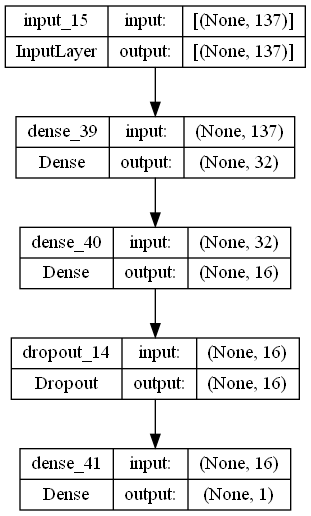

In [140]:
keras.utils.plot_model(training_model, show_shapes=True)

In [141]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,  restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.5, patience=1, verbose=1)
]

In [142]:
history = training_model.fit(
    preprocessed_train_ds, epochs=epochs, callbacks=callbacks, validation_data=preprocessed_val_ds, verbose=2
)

Epoch 1/30
7/7 - 1s - loss: 0.6880 - accuracy: 0.5236 - val_loss: 0.6729 - val_accuracy: 0.5275 - lr: 0.0010 - 1s/epoch - 167ms/step
Epoch 2/30
7/7 - 0s - loss: 0.6711 - accuracy: 0.5519 - val_loss: 0.6329 - val_accuracy: 0.7033 - lr: 0.0010 - 377ms/epoch - 54ms/step
Epoch 3/30
7/7 - 0s - loss: 0.6323 - accuracy: 0.6226 - val_loss: 0.6046 - val_accuracy: 0.8132 - lr: 0.0010 - 344ms/epoch - 49ms/step
Epoch 4/30
7/7 - 0s - loss: 0.6002 - accuracy: 0.6887 - val_loss: 0.5799 - val_accuracy: 0.8132 - lr: 0.0010 - 389ms/epoch - 56ms/step
Epoch 5/30
7/7 - 0s - loss: 0.5698 - accuracy: 0.7217 - val_loss: 0.5551 - val_accuracy: 0.8132 - lr: 0.0010 - 359ms/epoch - 51ms/step
Epoch 6/30
7/7 - 0s - loss: 0.5306 - accuracy: 0.7972 - val_loss: 0.5318 - val_accuracy: 0.8132 - lr: 0.0010 - 338ms/epoch - 48ms/step
Epoch 7/30
7/7 - 0s - loss: 0.5245 - accuracy: 0.7972 - val_loss: 0.5089 - val_accuracy: 0.8132 - lr: 0.0010 - 301ms/epoch - 43ms/step
Epoch 8/30
7/7 - 0s - loss: 0.5159 - accuracy: 0.7689 - v

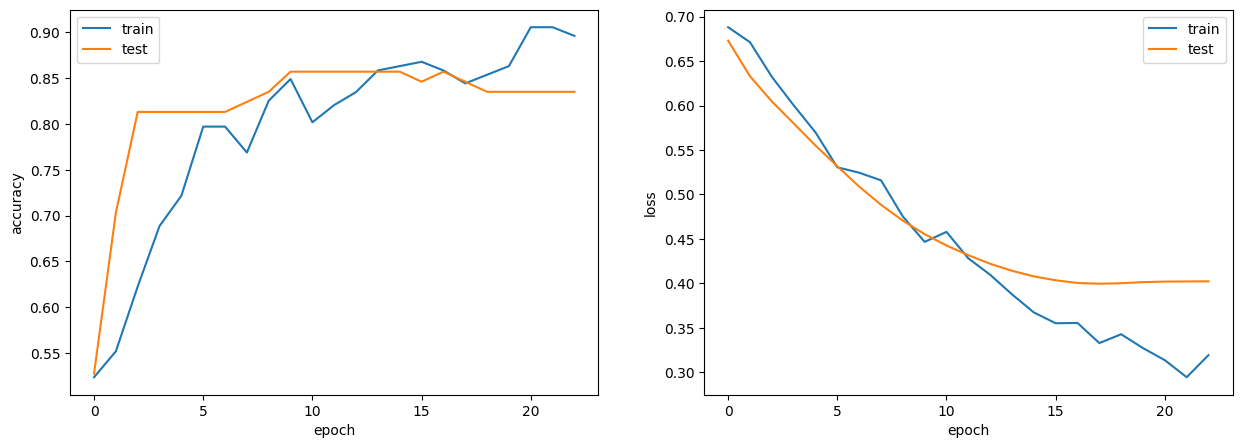

In [143]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'])


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'])

In [144]:
print(max(history.history['accuracy']))
print(max(history.history['val_accuracy']))

0.9056603908538818
0.8571428656578064
